# Copyright

<PRE>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19.

Any re-use or publication of any part of the notebook is only allowed with the
written consent of the authors.

2025 (c) Mohammed Salah Al-Radhi (malradhi@tmit.bme.hu)
</PRE>

Install necessary packages:
* PyTorch Lightning: high-level deep learning library over PyTorch.
* Weights and Biases: library used for logging metrics and model checkpoints.
* Datasets: library for loading datasets from the Hugging Face Hub (https://huggingface.co/datasets).

In [41]:
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets

Load the necessary libraries.

In [42]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import datasets
from transformers import pipeline

Login to WandB. Make sure that you have a valid WandB account. Ctrl + click on the link, copy the token from the opened page.

In [43]:
wandb.login()

True

## Hyperparameters

In [44]:
# we will use these later for the CNN
resolution = 112
num_classes = 3

batch_size = 32
num_workers = 2
num_epochs = 31
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

## Data pipeline

* We will be using the https://huggingface.co/datasets/lewtun/dog_food dataset.
* What is the difference between dataset and dataloader?
* What is the difference between image preprocessing and image augmentations? Look at the transforms. What do we use during training and validation?
* Best practices:
    * Set `num_workers > 0`. A good starting point is the number of CPU cores on your system.
    * If you use a GPU, set `pin_memory = True`. This improves the speed of CPU-to-GPU data transfer.
    * If you want to have a consistent batch_size in all iterations, set `drop_last = True`.
    * During training, set `shuffle = True`, which shuffles the order of frames in the dataset.

In [45]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()

In [46]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

## Visualization
* PyTorch uses channels first representation (batch, channels, height, width) vs channels last (batch, height, width, channels) by default. Keep that in mind during visualization, because matplotlib expects channels last format.

In [47]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

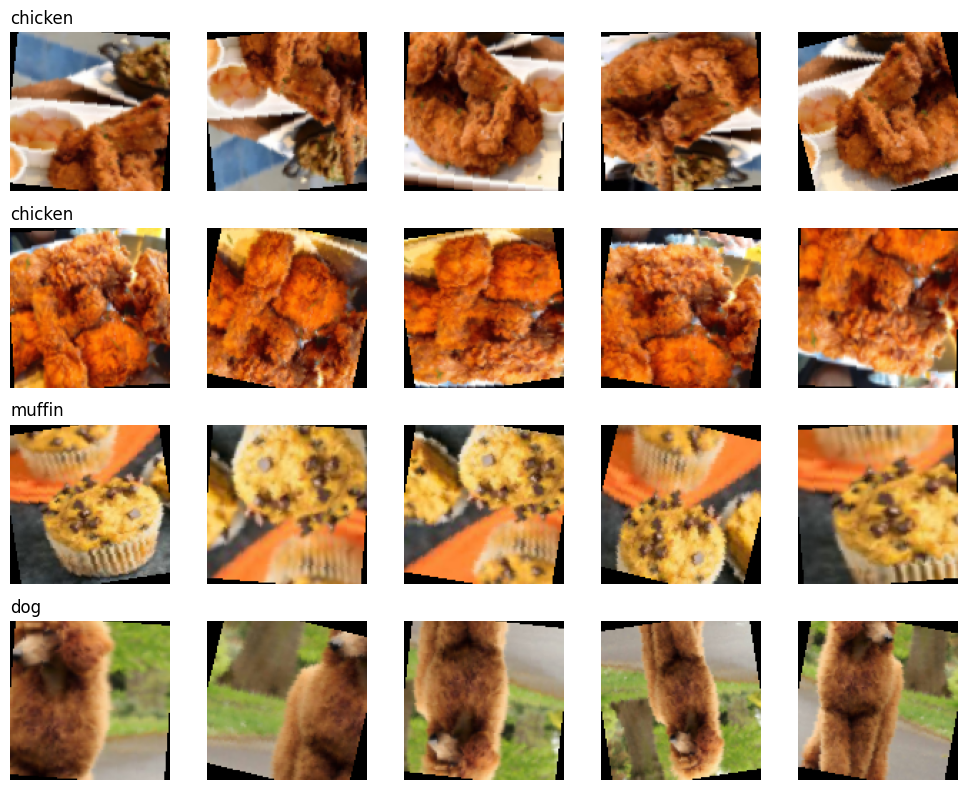

In [48]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

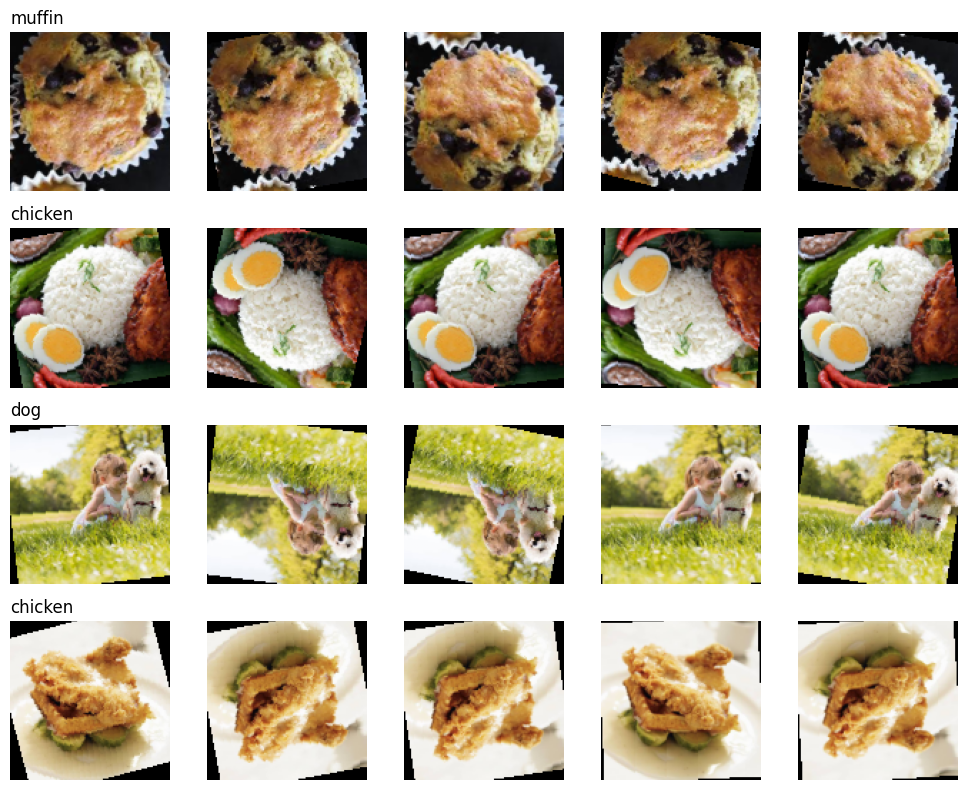

In [49]:
visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

## Classifier Model Definition

In [50]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.confusion_matrix.update(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        # return torch.optim.Adam(self.parameters(), lr=learning_rate)
        return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)


## Convolutional Neural Network Definiton

* Observe our custom CNN.
* What do each of the Conv2d parameters mean?
* What are the output shapes of each layer?
* What is a fully convolutional neural network? What is their advantage?

In [51]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width), # added batch norm after ReLu
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width), # added batch norm after ReLu
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width), # added batch norm after ReLu
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width), # added batch norm after ReLu
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

#model = torchvision.models.mobilenet_v2(num_classes=num_classes)

#model = torchvision.models.mobilenet_v2(num_classes=1000, weights="IMAGENET1K_V2")
# model.classifier[-1] = torch.nn.Linear(in_features=1280, out_features=num_classes, bias=True)

print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


# Best practices:
* Use 16-bit floating point mixed precision for >2x faster training and 2x lower GPU memory consumption.
* If using a PyTorch 2.x on a modern GPU (Volta or Ampere architecture e.g. V100 or A100), compile your neural network.
* For better GPU utilization, use larger batch sizes.

In [52]:
# model = torch.compile(model)
lit_model = ImageClassifier(model)

Number of parameters in the model without BatchNorm

In [53]:
def count_parameters_no_batchnorm(lit_model):
    return sum(p.numel() for p in lit_model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters_no_batchnorm(lit_model)}")

Number of trainable parameters: 113283


Number of parameters in the model with BatchNorm

In [54]:
def count_parameters_batchnorm(lit_model):
    return sum(p.numel() for p in lit_model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters_batchnorm(lit_model)}")

Number of trainable parameters: 113283


## Training
* We log our metrics using a `WandbLogger`.
* We save our best checkpoints using a `ModelCheckpoint` callback.

In [55]:
wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
wandb: WARNING `wandb.require('service')` is a no-op as it is now the default behavior.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type                      | Params | Mode 
-----------------------------------------------------------------------
0 | model            | Sequential                | 113 K  | train
1 | accuracy         | MulticlassAccuracy        | 0      | train
2 | confusion_matrix | MulticlassConfusionMatrix | 0      | train
-----------------------------------------------------------------------
113 K     Trainable params
0         Non-trainable

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=31` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇████
train_acc_epoch,▁▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█▇▇▇█████▇█
train_acc_step,▃▄▄▁▃▃▁▂▅▄▇▇▆▅▃▃▅█▇█▃▆▆▂▆▆▆▆▅▇▆▆▆▇██▆▆▇▆
train_loss_epoch,█▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁
train_loss_step,▆▆▅▆▆▆█▆▅▅▃▃▃▅▆▅▄▂▂▂▄▃▃▅▆▃▂▄▃▂▅▄▂▂▁▁▂▃▃▄
trainer/global_step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
val_acc,▄▄▅▄▆▅▅▆▆▅▆▆▇▅▇▆█▆█▇▁▇▆▆▇▇▇▇█▆▇
val_loss,▄▄▃▄▃▃▃▃▃▃▂▂▂▃▂▃▁▃▁▂█▂▂▃▁▂▁▂▁▃▂
epoch,30
train_acc_epoch,0.90982
train_acc_step,0.875


In [56]:
# if you stop your training early, run this line manually, to finish the wandb run
# wandb.finish()

# Tasks (during practice, solved together)
1. Visualize the augmented/preprocessed training/validation images. What do we see?
2. Turn image augmentations off in the training transforms.
3. Inspect the baseline CNN. What are the output shapes after each layer?
4. Run the baseline training.
5. Remove all ReLUs from our convolutional network. What do we expect? What do we see?
6. Replace the CNN with a MobilenetV2 network. How does it perform (train vs validation)? --> MobilnetV2 can be obtained from Huggingface
7. Add regularization to the training (turn on image augmentations, add weight decay, by replacing Adam with AdamW).
8. Load ImageNet-pretrained weights into the MobileNetV2 network and finetune it.
* **Warning 1**: ImageNet has 1000 classes, we only have 3. How does this affect the final layer of the network, what can we do?
* **Warning 2**: When using pretrained weights, we need to make sure that we use the same preprocessing as during pretraining. Turn pixel value normalization on in the transforms.
9. Try finetuning only the final classification layer of the network. How does this affect performance? What can be the advantages?

# Tasks (homework)
Your tasks are the following:
1. Add some other type of image augmentation to the training pipeline. Check out the list of available transforms here: https://pytorch.org/vision/main/transforms.html. Visualize the training images, save the generated figure.
2. Add batch normalization layers (2D) to our custom CNN, after each ReLU. Keep the network width at 64. What is the exact number of parameters in the original network? print it out! What is the exact number of trainable parameters in the new network? print it out!
3. Add a confusion matrix to your metrics (https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html). Run an evaluation, and visualize the confusion matrix.


# Homework Solutions

1. See DogFoodDataModule for additional transforms that were added

2.

* The number of parameters in the model without BatchNorm is 112771

* The number of parameters in the model with BatchNorm is 113283

* We have an increase in the total number of parameters by around 1000 when use BathNorm

3. Confusion Matrix

/tmp/ipython-input-916951768.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


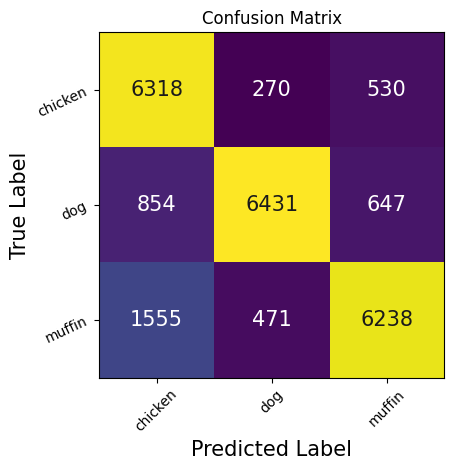

In [57]:
class_names = ["chicken", "dog", "muffin"]
fig, ax = lit_model.confusion_matrix.plot()
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.tight_layout()